In [238]:
import nltk
import numpy as np
import collections
import re
import pandas as pd
import matplotlib.pyplot as plt
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import SnowballStemmer
from csv_helper import CSVHelper
nltk.download('stopwords')
nltk.download('wordnet')

data = CSVHelper.load_csv("Tweets_2016London.csv")

[nltk_data] Downloading package stopwords to /home/jeroen/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jeroen/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
starting for loop!


In [239]:
def tokenize(tweets):
    tknzr = TweetTokenizer()
    tokenized_tweets = []
    for tweet in tweets:
        tokenized_tweets.append(tknzr.tokenize(tweet))
    return tokenized_tweets

def remove_stopwords(tweets):
    stopwords =  nltk.corpus.stopwords.words('english')
    stopwords.extend(("im","dont","wont"))
    tweets_nostop = []
    for tweet in tweets:
        tweet_nostop = [w.lower() for w in tweet if w.lower() not in stopwords]
        tweets_nostop.append(tweet_nostop)
    return tweets_nostop

def filter_names(tweets):
    tweets_filtered = []
    regex = re.compile("@([A-Za-z0-9_]+)")
    for tweet in tweets:
        tweet_filtered = [w for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

def filter_noise(tweets):
    tweets_filtered = []
    regex = re.compile("[^a-zA-Z]")
    for tweet in tweets:
        tweet_filtered = [re.sub("[^a-zA-Z]",'',w) for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

def remove_url(tweets):
    tweets_filtered = []
    regex = re.compile("^https?:\/\/.*[\r\n]*")
    for tweet in tweets:
        tweet_filtered = [w for w in tweet if not regex.match(w)]
        tweets_filtered.append(tweet_filtered)
    return tweets_filtered

#we decided to use a lemmatizer instead of stemming 
def my_stem(tweets):
    lmt = WordNetLemmatizer()
    ps = PorterStemmer()
    tweets_stemmed = []
    for tweet in tweets:
        tweet_stemmed = [lmt.lemmatize(w) for w in tweet]
        tweets_stemmed.append(tweet_stemmed)
    return tweets_stemmed

In [252]:
all_tweets = tokenize(data)
all_tweets = remove_url(all_tweets)
all_tweets = filter_names(all_tweets)
all_tweets = filter_noise(all_tweets)
all_tweets = remove_stopwords(all_tweets)
all_tweets = my_stem(all_tweets)


The function create_tfidf_features  (input = array of tokenized tweets output = tf-idf feature matrix) Creates a distinct vocabulary set, and a dictionary (key val pairs)for each word in the vocabulary, calculated the IDF value, and for each term in each tweet, calculates the tfidf score (which is just the term frequency * IDF value)


https://nlpforhackers.io/tf-idf/

https://www.youtube.com/watch?v=4vT4fzjkGCQ&t=1s

http://billchambers.me/tutorials/2014/12/21/tf-idf-explained-in-python.html

In [241]:
def termfreq(word, tweet):
    #print("tweet:", doc, "length of tweet:", len(doc))
    num_words = len(tweet)
    word_occurences = tweet.count(word)
    return word_occurences/num_words

def count_doc_with_term(word, tweets):
    counter = 0
    for tweet in tweets:
        if word in tweet:
            counter = counter + 1
    return counter

#idf = amount_of_tweets/amount_of_tweets_with_word
def idf(word, tweets):
    num_tweets = len(tweets)
    num_tweets_with_word = count_doc_with_term(word, tweets)
    return np.log10(num_tweets/num_tweets_with_word)

def create_vocabulary(tweets):
    vocabulary = set() #creates a new set named vocabulary (set doesn't have duplicates)
    for tweet in tweets: #iterates over all tweets
        words = [w for w in tweet] #makes a list of words in a tweet (which our loop currently is in)
        vocabulary.update(words)#update teh vocab set 
    return list(vocabulary)

def compute_word_idf(tweets, vocabulary):
    word_idf = collections.defaultdict(lambda: 0)    #when I call x[k] for a nonexistent key k (such as a statement like v=x[k]), the key-value pair (k,0) will be automatically added to the dictionary, as if the statement x[k]=0 is first executed.  
    for w in vocabulary: #looping across each word in library to calculate the word's idf
        word_idf[w] = idf(w, tweets) #taking the wordidf dictionaries' key as the word and putting value as the idf
    return word_idf
    
def tf_idf(word, tweet, tweets, word_idf):
    if tweet != []:
        return termfreq(word, tweet) * word_idf[word]
    else:
        return 0
    
def tweet_tfidf_features(tweets):
    vocabulary = create_vocabulary(tweets)
    word_idf = compute_word_idf(tweets, vocabulary)
    tweet_features = np.empty(len(tweets), dtype=object)
    for i, tweet in enumerate(tweets):
        a = np.zeros(len(vocabulary))
        for j, word in enumerate(vocabulary):
            a[j] = tf_idf(word, tweet, tweets,word_idf)
        tweet_features[i] = a
    return np.vstack(tweet_features)

What is happening inside tweet_tfidf_features?

1) vocabulary = create_vocabulary(tweets) Creates a vocabulary set (non duplicate values in all words)
2) word_idf = returns a dictionary where key is the word and value is the word's idk


In [242]:
#test = [["this","a","a","is","sample"],["this","another","another","is","example","example","example"]]
#test2 = [["new","times","york"],["new","post","york"],["angeles","los","times"],["pi","pa","po"],["teeet"],["teeet","o"],["pi","pa","po"]]
feature_matrix = tweet_tfidf_features(all_tweets)

In [243]:
feature_matrix.shape

(2001, 4480)

In [244]:
def euclidean_vectorized(A, B):    
    n, d = A.shape
    m, d1 = B.shape
    assert d == d1, 'Incompatible shape'
    A_squared = np.sum(np.square(A), axis=1, keepdims=True)
    B_squared = np.sum(np.square(B), axis=1, keepdims=True)
    AB = np.matmul(A, B.T)
    distances = np.sqrt(A_squared - 2 * AB + B_squared.T)
    return distances

# X: data matrix of size (n_samples,n_features)
# n_clusters: number of clusters
# output 1: labels of X with size (n_samples,)
# output 2: centroids of clusters
def kmeans(X,n_clusters):
    # initialize labels and prev_labels. prev_labels will be compared with labels to check if the stopping condition
    # have been reached.
    prev_labels = np.zeros(X.shape[0])
    labels = np.zeros(X.shape[0])
    
    # init random indices
    # YOUR CODE GOES HERE
    indices = np.random.choice(X.shape[0], n_clusters, replace=False)# np.random.permutation(X.shape[0])[:n_clusters]
    
    # assign centroids using the indices
    # YOUR CODE GOES HERE
    centroids = X[indices]
    
    # the interative algorithm goes here
    while (True):
        # calculate the distances to the centroids
        distances = euclidean_vectorized(X,centroids)
       
        # assign labels
        labels = np.argmin(distances,axis=1)
        # stopping condition
        if np.array_equal(labels, prev_labels):
        #if np.sum(labels != prev_labels) == 0:
            break
        
        # calculate new centroids
        for cluster_indx in range(centroids.shape[0]):
            members = X[labels == cluster_indx]
            centroids[cluster_indx,:] = np.mean(members,axis=0)
        
        # keep the labels for next round's usage
        prev_labels = np.argmin(distances,axis=1)
    
    return labels,centroids
    

In [245]:
from sklearn.cluster import KMeans
num_clusters = 5
cluster_labels,centroids = kmeans(feature_matrix,num_clusters)

-0.0167991960885
silhouette score for k= 2 is: 0.0590386605718
silhouette score for k= 3 is: 0.174738064082
silhouette score for k= 4 is: -0.111194186853
silhouette score for k= 5 is: -0.0781847546498
silhouette score for k= 6 is: -0.059678635965
silhouette score for k= 7 is: 0.0358810540343
silhouette score for k= 8 is: -0.0606352328357
silhouette score for k= 9 is: -0.00103747527546
silhouette score for k= 10 is: -0.0116471610575
silhouette score for k= 11 is: -0.155894887706
silhouette score for k= 12 is: -0.0592384434753
silhouette score for k= 13 is: -0.0663576573737
silhouette score for k= 14 is: -0.0876672457513
silhouette score for k= 15 is: -0.0375976409639


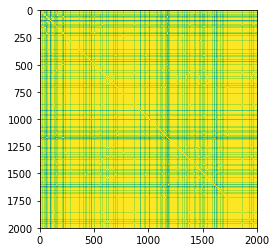

In [253]:
import sklearn
from sklearn.metrics import silhouette_score
print(silhouette_score(feature_matrix, cluster_labels))

nclusters_to_test = 16
consensus_matrix = np.zeros((feature_matrix.shape[0],feature_matrix.shape[0]))

for i in range(2,nclusters_to_test):
    cluster_labels, centroids = kmeans(feature_matrix, i)
    sil_score = silhouette_score(feature_matrix, cluster_labels)
    print("silhouette score for k=",i, 'is:',sil_score)
    for i in range(len(cluster_labels)):
        for j in range(len(cluster_labels)):
            if cluster_labels[i] == cluster_labels[j]:
                consensus_matrix[i,j] = (consensus_matrix[i,j] + 1)
                
import matplotlib.pyplot as plt

plt.imshow(consensus_matrix)
plt.legend()
plt.show()

#print(pd.DataFrame(consensus_matrix))

<h3>Additional post-processing step:</h3>
In this step, if a pair (i, j) of tweets did not cluster together more than 10% of the total number of runs, the position (i, j) in the consensus matrix is set to 0.

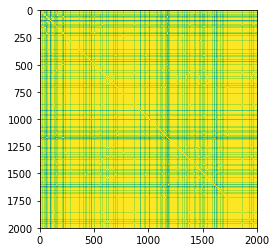

In [254]:
for i in range(len(consensus_matrix)):
    for j in range(len(consensus_matrix)):
        if consensus_matrix[i,j] <= 3:
            consensus_matrix[i,j] = 0

plt.imshow(consensus_matrix)
plt.legend()
plt.show()

#print(pd.DataFrame(consensus_matrix))

<h3>Marking Noise points</h3>
To detect noise, we will look at the row sums for the consensus
matrix and employed a threshold
value. Tweets, whose row sum are less than that threshold val
ue are, marked as noise points. The
threshold value is determined by the average of all the entri
es in the constructed consensus matrix.

In [255]:
row_mean = consensus_matrix.mean(1)
matrix_mean = consensus_matrix.mean()

#create clean tweats that removes the noise points
clean_tweets = []
for i in range(len(all_tweets)):
    if row_mean[i] >= matrix_mean:
        clean_tweets.append(all_tweets[i])
        


Running k-Means with the consensus matrix as input, number of clusters = 9

In [256]:
cluster_labels,centroids = kmeans(feature_matrix,9)
print(silhouette_score(feature_matrix, cluster_labels))

-0.0962901756942
